In [1]:
import os
import tensorflow as tf
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten
from keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D
from keras_self_attention import SeqSelfAttention
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import io

Using TensorFlow backend.


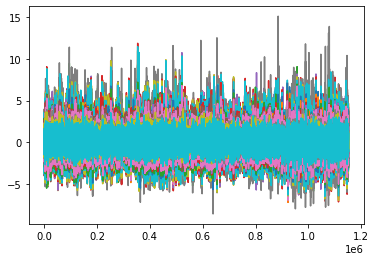

(50, 1152000)


In [3]:
set_num = 64
matdata = io.loadmat('data/signals.mat')
signals = numpy.zeros((50, 18000*set_num))
for i in range(set_num):
    signals[:,i*18000:(i+1)*18000]  = matdata['s'+str(i+1)]
plt.plot(signals.transpose())
plt.show()
print(signals.shape)

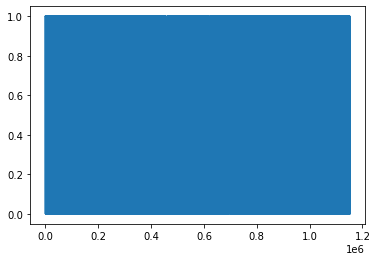

(1, 1152000)


In [4]:
matdata = io.loadmat('data/behaviors.mat')
behavis = numpy.zeros((1, 18000*set_num))
for i in range(set_num):
    behavis[:,i*18000:(i+1)*18000]  = matdata['b'+str(i+1)]
plt.plot(behavis.transpose())
plt.show()
print(behavis.shape)

In [5]:
dataset = numpy.hstack([signals.transpose().astype('float32'), behavis.transpose().astype('float32')])
print(dataset.shape)

(1152000, 51)


In [6]:
# # normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.5243208 , 0.4756588 , 0.52478135, ..., 0.52060586, 0.45601395,
        1.        ],
       [0.5294922 , 0.4874594 , 0.54577094, ..., 0.550915  , 0.44861886,
        1.        ],
       [0.53681123, 0.4916609 , 0.5472613 , ..., 0.5696357 , 0.44246095,
        1.        ],
       ...,
       [0.38074595, 0.3246355 , 0.42398232, ..., 0.33834928, 0.34063563,
        0.        ],
       [0.38334918, 0.31798124, 0.40275556, ..., 0.2984794 , 0.3288611 ,
        0.        ],
       [0.39405167, 0.34444982, 0.4290545 , ..., 0.3360081 , 0.3545482 ,
        0.        ]], dtype=float32)

In [7]:
# split into train and test sets
train_size = int(len(dataset) * 32/set_num)
valid_size = int(len(dataset) * 16/set_num)
test_size = len(dataset) - (train_size + valid_size)
train = dataset[0:train_size,:]
valid = dataset[train_size:(train_size + valid_size),:]
test = dataset[(train_size + valid_size):len(dataset),:]
print(len(train),len(valid), len(test))

576000 288000 288000


In [8]:
# convert an array of values into a dataset matrix
def create_dataset_back(dataset, look_frame):
    dataX, dataY = [], []
    for i in range(look_frame,len(dataset)):
        xset = []
        for j in range(dataset.shape[1]-1):
            a = dataset[(i-look_frame):i, j]
            xset.append(a)
        dataY.append(dataset[i, -1])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

look_frame = 10 #前ｎフレームまで読み込んで入力とする
trainX, trainY = create_dataset_back(train, look_frame)
print(trainX.shape)
print(trainY.shape)
validX, validY = create_dataset_back(valid, look_frame)
print(validX.shape)
print(validY.shape)
testX, testY = create_dataset_back(test, look_frame)
print(testX.shape)
print(testY.shape)

(575990, 50, 10)
(575990,)
(287990, 50, 10)
(287990,)
(287990, 50, 10)
(287990,)


In [9]:
# transpose input
input_train = trainX.transpose(0,2,1)
input_valid = validX.transpose(0,2,1)
input_test = testX.transpose(0,2,1)
print(input_train.shape)
print(input_valid.shape)
print(input_test.shape)

(575990, 10, 50)
(287990, 10, 50)
(287990, 10, 50)


In [10]:
# callback設定
modelCheckpoint = ModelCheckpoint(filepath = 'best_mmodel_attention.h5',
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min',
                                  period=1)

In [11]:
model = Sequential()
model.add(SeqSelfAttention(units = 96, attention_activation='relu', input_shape = (look_frame,trainX.shape[1])))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x=input_train, y=trainY, validation_data=(input_valid, validY), epochs=100, batch_size=256, verbose=1, callbacks=[modelCheckpoint])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_self_attention_1 (SeqSel (None, 10, 50)            9793      
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 10,294
Trainable params: 10,294
Non-trainable params: 0
_________________________________________________________________
Train on 575990 samples, validate on 287990 samples
Epoch 1/100
575990/575990 [==============================] - 7s 13us/step - loss: 0.5611 - accuracy: 0.7569 - val_loss: 0.4975 - val_accuracy: 0.8115

Epoch 00001: val_loss improved from inf to 0.49746, saving model to best_mmodel_attention.h5
Epoch 2/100
575990/575990 [==============================] - 7s 12us/step - loss: 0.

575990/575990 [==============================] - 7s 12us/step - loss: 0.3906 - accuracy: 0.8469 - val_loss: 0.3830 - val_accuracy: 0.8422

Epoch 00033: val_loss improved from 0.38557 to 0.38304, saving model to best_mmodel_attention.h5
Epoch 34/100
575990/575990 [==============================] - 7s 12us/step - loss: 0.3896 - accuracy: 0.8471 - val_loss: 0.3831 - val_accuracy: 0.8429

Epoch 00034: val_loss did not improve from 0.38304
Epoch 35/100
575990/575990 [==============================] - 8s 13us/step - loss: 0.3884 - accuracy: 0.8474 - val_loss: 0.3818 - val_accuracy: 0.8460

Epoch 00035: val_loss improved from 0.38304 to 0.38184, saving model to best_mmodel_attention.h5
Epoch 36/100
575990/575990 [==============================] - 7s 13us/step - loss: 0.3870 - accuracy: 0.8483 - val_loss: 0.3820 - val_accuracy: 0.8470

Epoch 00036: val_loss did not improve from 0.38184
Epoch 37/100
575990/575990 [==============================] - 7s 13us/step - loss: 0.3864 - accuracy: 0.8486 

575990/575990 [==============================] - 7s 13us/step - loss: 0.3621 - accuracy: 0.8591 - val_loss: 0.3698 - val_accuracy: 0.8529

Epoch 00070: val_loss did not improve from 0.36755
Epoch 71/100
575990/575990 [==============================] - 8s 14us/step - loss: 0.3617 - accuracy: 0.8592 - val_loss: 0.3716 - val_accuracy: 0.8507

Epoch 00071: val_loss did not improve from 0.36755
Epoch 72/100
575990/575990 [==============================] - 7s 13us/step - loss: 0.3614 - accuracy: 0.8592 - val_loss: 0.3674 - val_accuracy: 0.8510

Epoch 00072: val_loss improved from 0.36755 to 0.36744, saving model to best_mmodel_attention.h5
Epoch 73/100
575990/575990 [==============================] - 7s 13us/step - loss: 0.3609 - accuracy: 0.8597 - val_loss: 0.3769 - val_accuracy: 0.8517

Epoch 00073: val_loss did not improve from 0.36744
Epoch 74/100
575990/575990 [==============================] - 7s 13us/step - loss: 0.3602 - accuracy: 0.8600 - val_loss: 0.3690 - val_accuracy: 0.8528

Epo

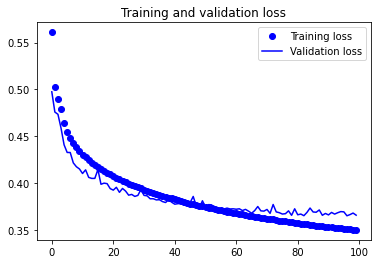

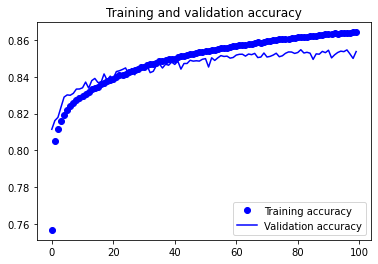

In [12]:
# plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [13]:
# Predict
model = load_model('best_mmodel_attention.h5', custom_objects=SeqSelfAttention.get_custom_objects())
trainPredict = model.predict(input_train)
validPredict = model.predict(input_valid)
testPredict = model.predict(input_test)

In [14]:
# make predictions
pad_col = numpy.zeros(dataset.shape[1]-1)
def pad_array(val):
    return numpy.array([numpy.insert(pad_col, dataset.shape[1]-1, x) for x in val])

trainPredict1 = scaler.inverse_transform(pad_array(trainPredict))
trainY1 = scaler.inverse_transform(pad_array(trainY))

validPredict1 = scaler.inverse_transform(pad_array(validPredict))
validY1 = scaler.inverse_transform(pad_array(validY))

testPredict1 = scaler.inverse_transform(pad_array(testPredict))
testY1 = scaler.inverse_transform(pad_array(testY))

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY1[:,dataset.shape[1]-1], trainPredict1[:,dataset.shape[1]-1]))
print('Train Score: %.2f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY1[:,dataset.shape[1]-1], validPredict1[:,dataset.shape[1]-1]))
print('Valid Score: %.2f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(testY1[:,dataset.shape[1]-1], testPredict1[:,dataset.shape[1]-1]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.32 RMSE
Valid Score: 0.33 RMSE
Test Score: 0.33 RMSE


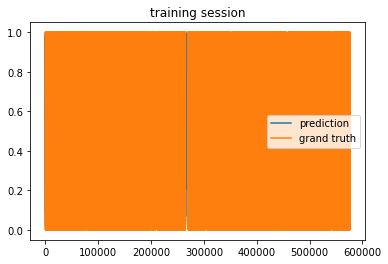

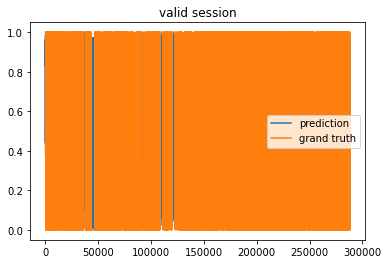

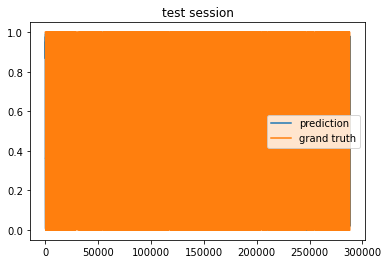

In [15]:
# plot baseline and predictions
plt.plot(trainPredict1[:,dataset.shape[1]-1], label="prediction")
plt.plot(trainY1[:,dataset.shape[1]-1], label="grand truth")
plt.title("training session")
plt.legend()
plt.show()
plt.plot(validPredict1[:,dataset.shape[1]-1], label="prediction")
plt.plot(validY1[:,dataset.shape[1]-1], label="grand truth")
plt.title("valid session")
plt.legend()
plt.show()
plt.plot(testPredict1[:,dataset.shape[1]-1], label="prediction")
plt.plot(testY1[:,dataset.shape[1]-1], label="grand truth")
plt.title("test session")
plt.legend()
plt.show()

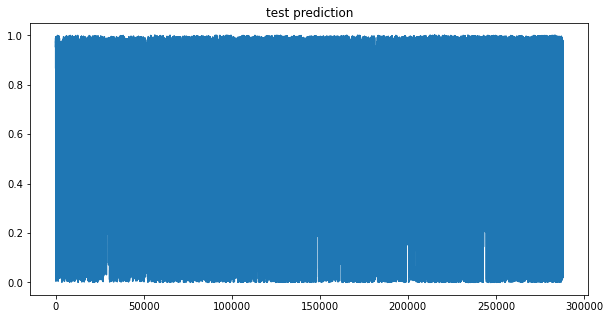

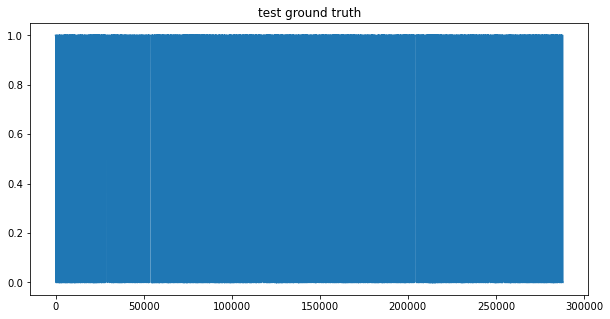

In [16]:
plt.figure(figsize=(10.0, 5.0))
plt.plot(testPredict1[:,dataset.shape[1]-1])
plt.title("test prediction")
plt.show()
plt.figure(figsize=(10.0, 5.0))
plt.plot(testY1[:,dataset.shape[1]-1])
plt.title("test ground truth")
plt.show()

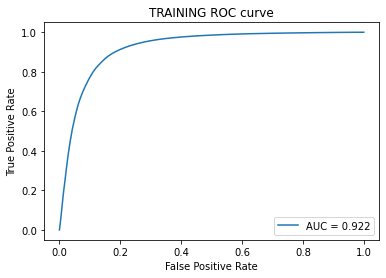

AUCは
0.9221225675528816
です。
最適な閾値は
0.554179847240448
です。


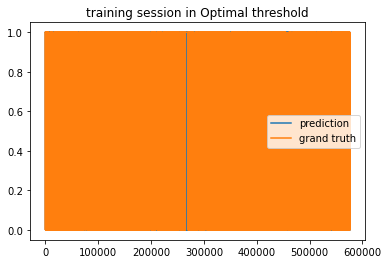

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

y_test, y_pred = trainY1[:,dataset.shape[1]-1], trainPredict1[:,dataset.shape[1]-1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
AUC = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
plt.title("TRAINING ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
print('AUCは')
print(auc(fpr, tpr))
print('です。')
print('最適な閾値は')
opt_thr = thresholds[numpy.argmax(tpr - fpr)]
print(opt_thr)
print('です。')
plt.plot(trainPredict1[:,dataset.shape[1]-1] > opt_thr, label="prediction")
plt.plot(trainY1[:,dataset.shape[1]-1], label="grand truth")
plt.title("training session in Optimal threshold")
plt.legend()
plt.show()

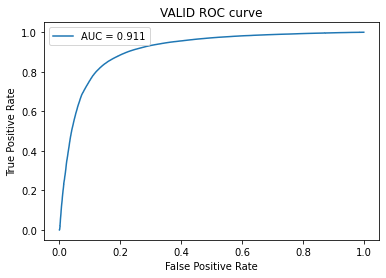

AUCは
0.9109327516393367
です。
最適な閾値は
0.6082659363746643
です。


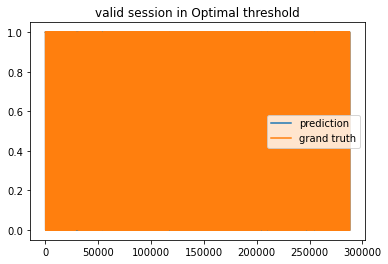

In [18]:
y_test, y_pred = validY1[:,dataset.shape[1]-1], validPredict1[:,dataset.shape[1]-1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
AUC = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
plt.title("VALID ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
print('AUCは')
print(auc(fpr, tpr))
print('です。')
print('最適な閾値は')
opt_thr = thresholds[numpy.argmax(tpr - fpr)]
print(opt_thr)
print('です。')
plt.plot(testPredict1[:,dataset.shape[1]-1] > opt_thr, label="prediction")
plt.plot(testY1[:,dataset.shape[1]-1], label="grand truth")
plt.title("valid session in Optimal threshold")
plt.legend()
plt.show()

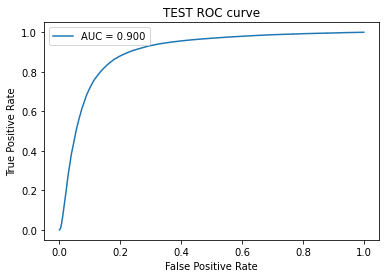

AUCは
0.8995689647492404
です。
最適な閾値は
0.5769920945167542
です。


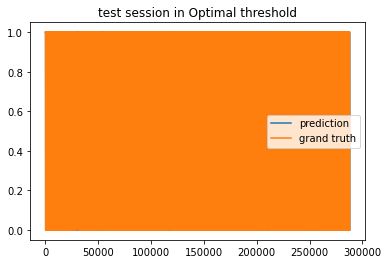

In [19]:
y_test, y_pred = testY1[:,dataset.shape[1]-1], testPredict1[:,dataset.shape[1]-1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
AUC = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
plt.title("TEST ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
print('AUCは')
print(auc(fpr, tpr))
print('です。')
print('最適な閾値は')
opt_thr = thresholds[numpy.argmax(tpr - fpr)]
print(opt_thr)
print('です。')
plt.plot(testPredict1[:,dataset.shape[1]-1] > opt_thr, label="prediction")
plt.plot(testY1[:,dataset.shape[1]-1], label="grand truth")
plt.title("test session in Optimal threshold")
plt.legend()
plt.show()